## DATASET MAPPING

In [1]:
import pandas as pd

# Load the census dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'marital-status', 'occupation', 'relationship', 'race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
census_df = pd.read_csv(url, names=column_names, na_values=' ?')

In [2]:
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [3]:
census_df['marital-status'].unique()

array([' Never-married', ' Married-civ-spouse', ' Divorced',
       ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
       ' Widowed'], dtype=object)

In [4]:
# Mapping married and unmarried statuses
marital_mapping = {
    ' Never-married': 'Unmarried',
    ' Married-civ-spouse': 'Married',
    ' Divorced': 'Married',  # Consider divorced as married
    ' Married-spouse-absent': 'Married',
    ' Separated': 'Married',
    ' Married-AF-spouse': 'Married',
    ' Widowed': 'Married'
}

# Map the values in the 'marital-status' column
census_df['marital-status'] = census_df['marital-status'].map(marital_mapping)

## Handling Missing Values - Mode Imputation

In [5]:
# Check for missing values in each column
missing_values = census_df.isnull().sum()

# Display columns with missing values
print("Columns with missing values:")
print(missing_values[missing_values > 0])

Columns with missing values:
workclass         1836
occupation        1843
native-country     583
dtype: int64


In [6]:
# Mode imputation for categorical columns
categorical_columns = ['workclass', 'occupation', 'native-country']
for column in categorical_columns:
    mode_value = census_df[column].mode()[0]  # Calculate the mode
    census_df[column].fillna(mode_value, inplace=True)  # Fill missing values with mode

In [7]:
# Check for missing values in each column
missing_values = census_df.isnull().sum()
print(missing_values)

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


In [8]:
census_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Unmarried,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Married,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## SQL DATABASE CONNECTION

In [9]:
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('census_data.db')

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

# Create the table
create_table_query = """
CREATE TABLE census_df (
    Age INTEGER,
    Workclass TEXT,
    Final_Weight INTEGER,
    Education TEXT,
    Education_Num INTEGER,
    Marital_Status TEXT,
    Occupation TEXT,
    Relationship TEXT,
    Race TEXT,
    Sex TEXT,
    Capital_Gain INTEGER,
    Capital_Loss INTEGER,
    Hours_Per_Week INTEGER,
    Native_Country TEXT,
    Income TEXT
);
"""
cursor.execute(create_table_query)

# Iterate over the rows of the DataFrame and construct the query for each row
for index, row in census_df.iterrows():
    # Extract values from the current row
    values = tuple(row)

    # Construct the query with the values
    query = f"""INSERT INTO census_df (age, workclass, Final_Weight, education, education_num, marital_status, occupation, relationship, race, sex, capital_gain, capital_loss, hours_per_week, native_country, income)
                VALUES {values}"""

    # Execute the query
    cursor.execute(query)

# Commit the changes to the database
conn.commit()

In [10]:
query = """SELECT Final_weight FROM census_df limit 10""";
cursor.execute(query)
result = cursor.fetchall()
print(result)

[(77516,), (83311,), (215646,), (234721,), (338409,), (284582,), (160187,), (209642,), (45781,), (159449,)]


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def efficient_aggregate_sql(data, attributes_numeric, attributes_categorical,key):
    # Create a connection to an in-memory SQLite database
    conn = sqlite3.connect('census_data.db')
    # Create a cursor object
    cursor = conn.cursor()

    # Construct the SQL query for efficient aggregation
    numeric_aggregates = ', '.join([f'AVG({attributes_numeric[i]}) AS mean_{attributes_numeric[i]}, SUM({attributes_numeric[i]}) AS sum_{attributes_numeric[i]}, COUNT({attributes_numeric[i]}) AS count_{attributes_numeric[i]}, MIN({attributes_numeric[i]}) AS min_{attributes_numeric[i]}, MAX({attributes_numeric[i]}) AS max_{attributes_numeric[i]}' for i in range(len(attributes_numeric))])
    categorical_attributes = ', '.join(attributes_categorical)
    query =  f"""
        SELECT
            {categorical_attributes},
            {numeric_aggregates}
        FROM census_df
        GROUP BY """ + ','.join(attributes_categorical)+";"


    # Execute the SQL query
    cursor.execute(query)
    # Fetch the results
    results = cursor.fetchall()
    # Convert results to DataFrame
    columns = attributes_categorical + [f'{agg}_{attributes_numeric[i]}' for i in range(len(attributes_numeric)) for agg in ['mean', 'sum', 'count', 'min', 'max']]
    aggregated_data = pd.DataFrame(results, columns=columns)

    query_married = f"""
        SELECT
            {categorical_attributes},
            {numeric_aggregates}
        FROM census_df
        where Marital_Status = 'Married'
        GROUP BY marital_status,{key};
    """

    query_unmarried = f"""
        SELECT
            {categorical_attributes},
            {numeric_aggregates}
        FROM census_df
        where Marital_Status = 'Unmarried'
        GROUP BY Marital_Status,{key};
    """
    # Execute the SQL query
    cursor.execute(query_married)
    # Fetch the results
    results_married = cursor.fetchall()
    # Convert results to DataFrame
    columns = attributes_categorical + [f'{agg}_{attributes_numeric[i]}' for i in range(len(attributes_numeric)) for agg in ['mean', 'sum', 'count', 'min', 'max']]
    aggregated_data_married = pd.DataFrame(results_married, columns=columns)

    # Execute the SQL query
    cursor.execute(query_unmarried)
    # Fetch the results
    results_unmarried = cursor.fetchall()
    # Close the cursor and connection
    cursor.close()
    conn.close()
    # Convert results to DataFrame
    columns = attributes_categorical + [f'{agg}_{attributes_numeric[i]}' for i in range(len(attributes_numeric)) for agg in ['mean', 'sum', 'count', 'min', 'max']]
    aggregated_data_unmarried = pd.DataFrame(results_unmarried, columns=columns)

    return aggregated_data,aggregated_data_married,aggregated_data_unmarried

In [ ]:
aggregated_data_married

In [13]:
from scipy.stats import entropy

# Define utility function to calculate K-L Divergence
def calculate_kl_divergence(p, q):
    return entropy(p, q)

def get_kl_divergences(aggregated_data_married, aggregated_data_unmarried, attributes_numerical, attributes_categorical,key):
    kl_divergences = {}

    # Iterate over common columns between married and unmarried data
    common_columns = set(aggregated_data_married.columns) & set(aggregated_data_unmarried.columns)
    for column in common_columns:
        if column.startswith('sum_') or column.startswith('mean_') or column.startswith('max_') or column.startswith('min_') or column.startswith('count_'):
            #print(column, "Column2")
            # Normalize data into probability distribution
            total_count_married = aggregated_data_married[column].sum()
            total_count_unmarried = aggregated_data_unmarried[column].sum()
            #print(total_count_married,total_count_unmarried,column,"Test3")
            epsilon = 1e-9  # Small epsilon value to avoid division by zero
            probability_distribution_married = (aggregated_data_married[column] + epsilon) / (total_count_married + epsilon)
            probability_distribution_unmarried = (aggregated_data_unmarried[column] + epsilon) / (total_count_unmarried + epsilon)
            '''
            # Handling outliers
            lower_bound = probability_distribution_married.quantile(0.05)
            upper_bound = probability_distribution_married.quantile(0.95)
            probability_distribution_married = probability_distribution_married.clip(lower=lower_bound, upper=upper_bound, axis=0)

            lower_bound = probability_distribution_unmarried.quantile(0.05)
            upper_bound = probability_distribution_unmarried.quantile(0.95)
            probability_distribution_unmarried = probability_distribution_unmarried.clip(lower=lower_bound, upper=upper_bound, axis=0)
            '''
            #print("married_prob_dist:", probability_distribution_married)
            #print("unmarried_prob_dist:", probability_distribution_unmarried)

            kl_score = calculate_kl_divergence(probability_distribution_married, probability_distribution_unmarried)
            #print(kl_score,column,"Test")
            #print("kl_score: ", kl_score)
            if kl_score > 0.0000001:  # Apply pruning condition
                kl_divergences[column+","+key] = kl_score

    return kl_divergences


In [14]:
attributes_numeric     = ['age', 'Final_Weight', 'education_num','capital_gain', 'capital_loss', 'hours_per_week']
attributes_categorical = ['Income','WorkClass','Education','Marital_Status','Occupation','Relationship','Race','Native_country','Sex']
kl_divergences = {}
for cat_attribute in attributes_categorical:
    if cat_attribute == "Marital_Status"  or cat_attribute == "Relationship" or cat_attribute=="Native_country": continue
    print(cat_attribute)
    aggregated_data,aggregated_data_married,aggregated_data_unmarried = efficient_aggregate_sql(census_df, attributes_numeric,attributes_categorical, cat_attribute)
    kl_current = get_kl_divergences(aggregated_data_married,aggregated_data_unmarried,attributes_numeric,attributes_categorical, cat_attribute)
    kl_divergences.update(kl_current)




Income
WorkClass
Education
Occupation
Race
Sex


In [ ]:
'''
# Compute K-L Divergences for each aggregation

attributes_numerical     = ['age', 'FinalWeight', 'education_num','capital_gain', 'capital_loss', 'hours_per_week']
attributes_categorical = ['Income','WorkClass','Education','Occupation','Relationship','Race','Native_country','Sex']

kl_divergences = get_kl_divergences(aggregated_data_married,aggregated_data_unmarried,attributes_numerical,attributes_categorical)

print("kl_divergences:",kl_divergences)
'''

In [15]:
kl_divergences

{'count_education_num,Income': 0.42765485144507676,
 'count_capital_gain,Income': 0.42765485144507676,
 'mean_age,Income': 0.010424871878964445,
 'count_hours_per_week,Income': 0.42765485144507676,
 'min_hours_per_week,Income': 0.4133392862708054,
 'sum_age,Income': 0.35186992916206,
 'count_Final_Weight,Income': 0.42765485144507676,
 'mean_education_num,Income': 0.00018130798174249667,
 'max_capital_gain,Income': 0.0037074838017703143,
 'sum_capital_loss,Income': 0.5375667779352091,
 'min_education_num,Income': 0.01737200036916739,
 'max_hours_per_week,Income': 0.0011350742672455935,
 'min_Final_Weight,Income': 0.03952448006175063,
 'mean_Final_Weight,Income': 2.3335452958812364e-07,
 'max_Final_Weight,Income': 0.0024931277747803557,
 'max_capital_loss,Income': 0.08421422055188055,
 'sum_Final_Weight,Income': 0.4280359732946558,
 'mean_capital_loss,Income': 0.0037194996015654444,
 'sum_capital_gain,Income': 0.08996615994823105,
 'sum_hours_per_week,Income': 0.4135006347320226,
 'count

In [16]:
views = sorted(kl_divergences.items(), key=lambda x: x[1], reverse=True)
print(len(views))
views

156


[('mean_capital_loss,Occupation', 9.137373729057726),
 ('max_capital_loss,Education', 2.516445123250752),
 ('mean_capital_loss,Education', 2.486136686357034),
 ('max_capital_gain,Education', 1.5018927749580238),
 ('mean_capital_gain,Education', 1.460488448513597),
 ('max_capital_loss,Occupation', 1.2651442137261115),
 ('min_hours_per_week,WorkClass', 0.6601282369937029),
 ('min_hours_per_week,Occupation', 0.6273236895856313),
 ('sum_capital_loss,Income', 0.5375667779352091),
 ('max_capital_gain,Race', 0.523848219053851),
 ('mean_capital_gain,Race', 0.5020902977501602),
 ('mean_capital_gain,WorkClass', 0.48550153292378634),
 ('max_capital_gain,Occupation', 0.48350929028084116),
 ('sum_education_num,Income', 0.46244256154516816),
 ('sum_Final_Weight,Income', 0.4280359732946558),
 ('count_education_num,Income', 0.42765485144507676),
 ('count_capital_gain,Income', 0.42765485144507676),
 ('count_hours_per_week,Income', 0.42765485144507676),
 ('count_Final_Weight,Income', 0.42765485144507676

## Top 5 views

In [19]:
top_5_views = views[:5]

In [20]:
top_5_views

[('mean_capital_loss,Occupation', 9.137373729057726),
 ('max_capital_loss,Education', 2.516445123250752),
 ('mean_capital_loss,Education', 2.486136686357034),
 ('max_capital_gain,Education', 1.5018927749580238),
 ('mean_capital_gain,Education', 1.460488448513597)]

In [21]:
# Extracting attribute, measure, and KL divergence from the list of tuples
key = [view[0].split(",")[1] for view in views]
attributes_total = [view[0].split(",")[0] for view in views]
kl_divergences_total = [view[1] for view in views]

# Create DataFrame
df_views = pd.DataFrame({
    'key': key,
    'Attribute': attributes_total,
    'KL Divergence': kl_divergences_total
})

# Display the DataFrame
df_views

,key,Attribute,KL Divergence
0,Occupation,mean_capital_loss,9.137374e+00
1,Education,max_capital_loss,2.516445e+00
2,Education,mean_capital_loss,2.486137e+00
3,Education,max_capital_gain,1.501893e+00
4,Education,mean_capital_gain,1.460488e+00
...,...,...,...
151,Sex,mean_Final_Weight,1.818393e-04
152,Income,mean_education_num,1.813080e-04
153,Sex,max_Final_Weight,7.388642e-05
154,Sex,mean_age,3.370779e-06


In [22]:
# Extracting attribute, measure, and KL divergence from the list of tuples
key = [view[0].split(",")[1] for view in top_5_views]
attributes = [view[0].split(",")[0] for view in top_5_views]
kl_divergences = [view[1] for view in top_5_views]

# Create DataFrame
df_top_views = pd.DataFrame({
    'key': key,
    'Attribute': attributes,
    'KL Divergence': kl_divergences
})

# Display the DataFrame
df_top_views

,key,Attribute,KL Divergence
0,Occupation,mean_capital_loss,9.137374
1,Education,max_capital_loss,2.516445
2,Education,mean_capital_loss,2.486137
3,Education,max_capital_gain,1.501893
4,Education,mean_capital_gain,1.460488


## Plot

In [23]:
aggregated_data

,Income,WorkClass,Education,Marital_Status,Occupation,Relationship,Race,Native_country,Sex,mean_age,...,mean_capital_loss,sum_capital_loss,count_capital_loss,min_capital_loss,max_capital_loss,mean_hours_per_week,sum_hours_per_week,count_hours_per_week,min_hours_per_week,max_hours_per_week
0,<=50K,Federal-gov,10th,Married,Craft-repair,Husband,White,United-States,Male,62.000000,...,0.0,0,2,0,0,40.000000,80,2,40,40
1,<=50K,Federal-gov,10th,Married,Craft-repair,Not-in-family,White,United-States,Male,50.000000,...,0.0,0,1,0,0,56.000000,56,1,56,56
2,<=50K,Federal-gov,10th,Married,Craft-repair,Unmarried,White,United-States,Male,65.000000,...,0.0,0,1,0,0,40.000000,40,1,40,40
3,<=50K,Federal-gov,10th,Married,Other-service,Not-in-family,White,United-States,Female,59.000000,...,0.0,0,1,0,0,37.000000,37,1,37,37
4,<=50K,Federal-gov,10th,Married,Other-service,Wife,Amer-Indian-Eskimo,United-States,Female,28.000000,...,0.0,0,1,0,0,40.000000,40,1,40,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8324,>50K,State-gov,Some-college,Married,Protective-serv,Husband,Black,United-States,Male,46.000000,...,0.0,0,1,0,0,70.000000,70,1,70,70
8325,>50K,State-gov,Some-college,Married,Protective-serv,Husband,White,United-States,Male,50.666667,...,317.0,1902,6,0,1902,40.166667,241,6,40,41
8326,>50K,State-gov,Some-college,Married,Protective-serv,Not-in-family,White,United-States,Male,31.000000,...,0.0,0,1,0,0,40.000000,40,1,40,40
8327,>50K,State-gov,Some-college,Married,Protective-serv,Unmarried,Amer-Indian-Eskimo,United-States,Female,38.000000,...,0.0,0,1,0,0,40.000000,40,1,40,40


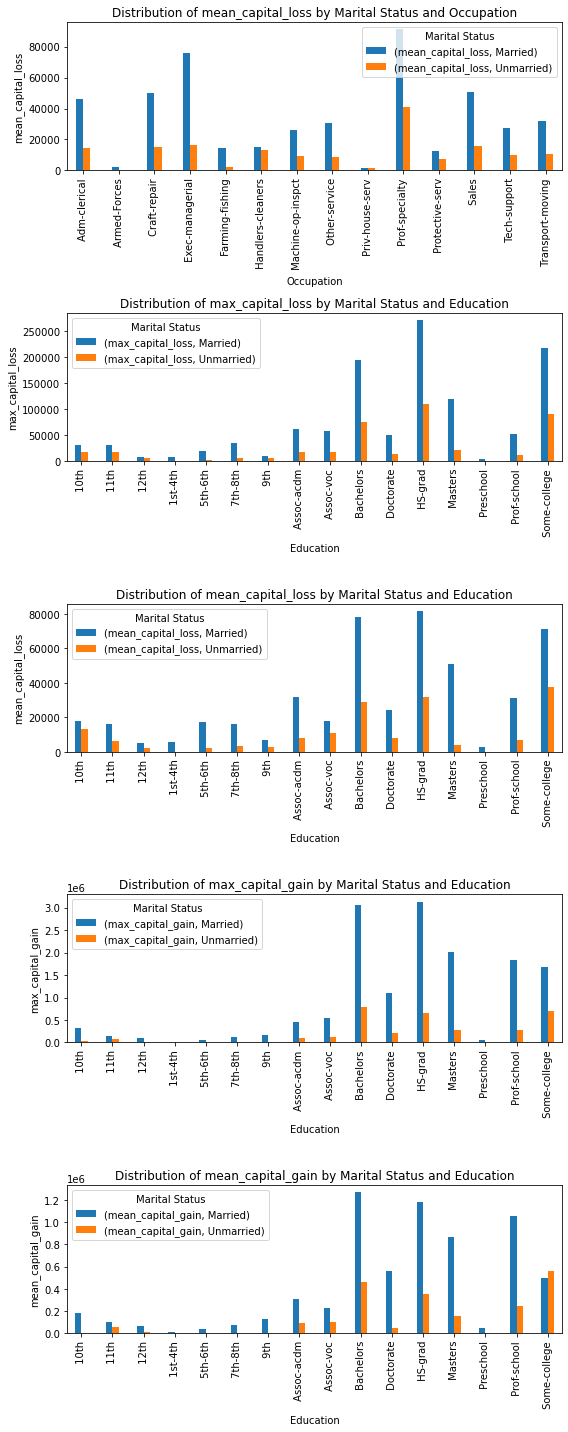

In [24]:
import matplotlib.pyplot as plt

# Extracting attribute names from top_5_views
attributes = [view[0] for view in top_5_views]

# Create subplots
fig, axes = plt.subplots(nrows=len(attributes), ncols=1, figsize=(8, len(attributes) * 4))

# Iterate through each attribute
for idx, attribute in enumerate(attributes):
    ax = axes[idx]
    att = attribute.split(",")[0]
    key = attribute.split(",")[1]

    # Filter data for the current attribute
    #aggregated_data, a, b = efficient_aggregate_sql()
    attribute_data = aggregated_data[[att, 'Marital_Status', key]]
    #print(attribute_data)

    # Group data by Marital_Status and Sex and aggregate counts
    grouped_data = attribute_data.groupby([key, 'Marital_Status']).sum().unstack(level=1)

    # Plot bars for married and unmarried individuals
    grouped_data.plot(kind='bar', ax=ax, stacked=False, width=0.4)  # Set width for each bar

    # Set plot title
    ax.set_title(f'Distribution of {att} by Marital Status and {key}')

    # Set x and y labels
    ax.set_xlabel(key)
    ax.set_ylabel(att)

    # Set legend
    ax.legend(title='Marital Status')

    # Set x-axis ticks and labels
    ax.set_xticks(range(len(grouped_data.index)))
    ax.set_xticklabels(grouped_data.index)
#plt.ticklabel_format(style = 'plain')

# Adjust layout
plt.tight_layout()
plt.show()

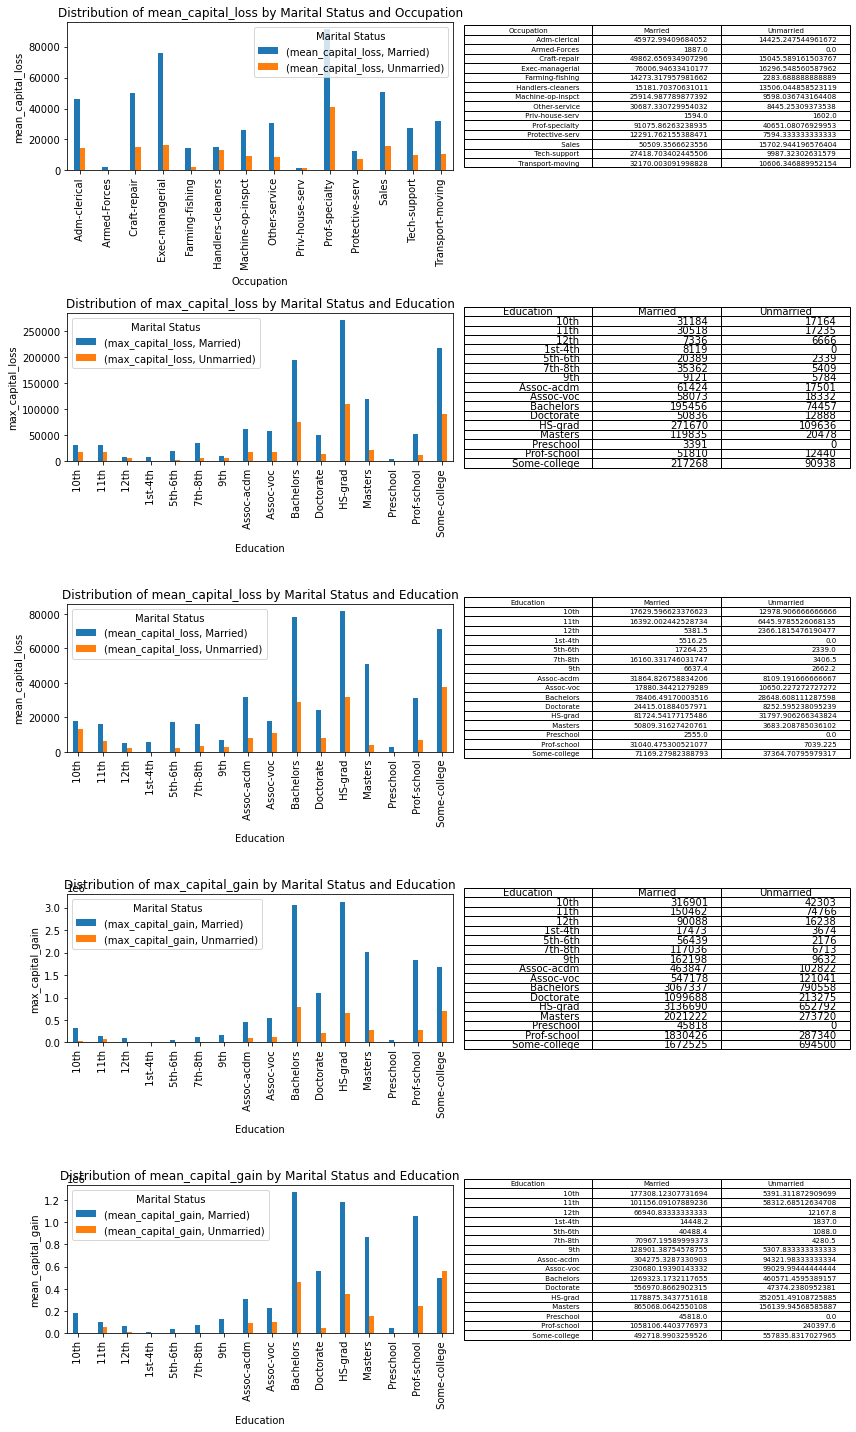

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Extracting attribute names from top_5_views
attributes = [view[0] for view in top_5_views]

# Create subplots
fig, axes = plt.subplots(nrows=len(attributes), ncols=2, figsize=(12, len(attributes) * 4))

# Iterate through each attribute
for idx, attribute in enumerate(attributes):
    ax = axes[idx, 0]
    table_ax = axes[idx, 1]
    att = attribute.split(",")[0]
    key = attribute.split(",")[1]

    # Filter data for the current attribute
    attribute_data = aggregated_data[[att, 'Marital_Status', key]]

    # Group data by Marital_Status and Sex and aggregate counts
    grouped_data = attribute_data.groupby([key, 'Marital_Status']).sum().unstack(level=1)

    # Plot bars for married and unmarried individuals
    grouped_data.plot(kind='bar', ax=ax, stacked=False, width=0.4)  # Set width for each bar

    # Set plot title
    ax.set_title(f'Distribution of {att} by Marital Status and {key}')

    # Set x and y labels
    ax.set_xlabel(key)
    ax.set_ylabel(att)

    # Set legend
    ax.legend(title='Marital Status')

    # Set x-axis ticks and labels
    ax.set_xticks(range(len(grouped_data.index)))
    ax.set_xticklabels(grouped_data.index)

    # Create DataFrame for the table
    table_data = grouped_data.reset_index()
    table_data.columns = [key] + ['Married', 'Unmarried']
    
    # Create table
    cell_text = []
    for i in range(len(table_data)):
        cell_text.append(table_data.iloc[i].values)
    table_ax.axis('off')
    table = table_ax.table(cellText=cell_text, colLabels=table_data.columns, loc='center')

# Adjust layout
plt.tight_layout()
plt.show()


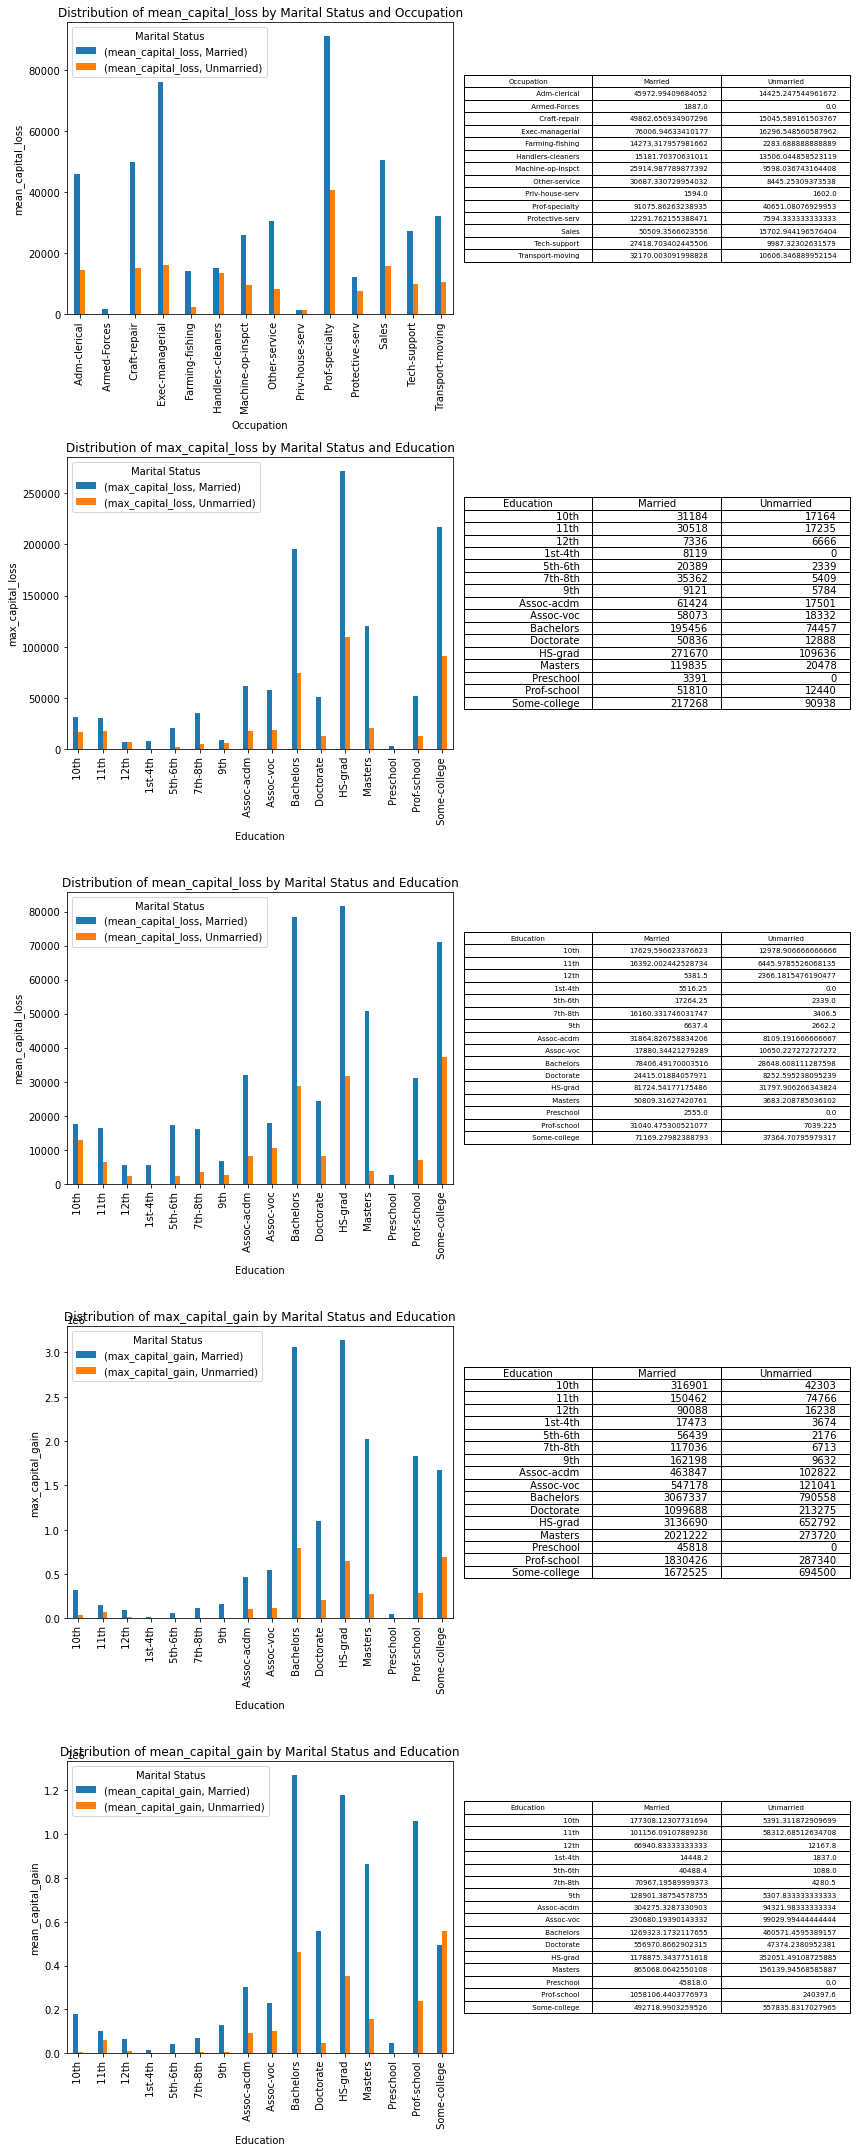

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Extracting attribute names from top_5_views
attributes = [view[0] for view in top_5_views]

# Create subplots with increased height for tables
fig, axes = plt.subplots(nrows=len(attributes), ncols=2, figsize=(12, len(attributes) * 6))  # Increased height

# Iterate through each attribute
for idx, attribute in enumerate(attributes):
    ax = axes[idx, 0]
    table_ax = axes[idx, 1]
    att = attribute.split(",")[0]
    key = attribute.split(",")[1]

    # Filter data for the current attribute
    attribute_data = aggregated_data[[att, 'Marital_Status', key]]

    # Group data by Marital_Status and Sex and aggregate counts
    grouped_data = attribute_data.groupby([key, 'Marital_Status']).sum().unstack(level=1)

    # Plot bars for married and unmarried individuals
    grouped_data.plot(kind='bar', ax=ax, stacked=False, width=0.4)  # Set width for each bar

    # Set plot title
    ax.set_title(f'Distribution of {att} by Marital Status and {key}')

    # Set x and y labels
    ax.set_xlabel(key)
    ax.set_ylabel(att)

    # Set legend
    ax.legend(title='Marital Status')

    # Set x-axis ticks and labels
    ax.set_xticks(range(len(grouped_data.index)))
    ax.set_xticklabels(grouped_data.index)

    # Create DataFrame for the table
    table_data = grouped_data.reset_index()
    table_data.columns = [key] + ['Married', 'Unmarried']
    
    # Create table
    cell_text = []
    for i in range(len(table_data)):
        cell_text.append(table_data.iloc[i].values)
    table_ax.axis('off')
    table = table_ax.table(cellText=cell_text, colLabels=table_data.columns, loc='center')

# Adjust layout
plt.tight_layout()
plt.show()
